In [128]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib.animation as animation

In [369]:
def random_flower_attraction(features=2, num_flowers = 10, max_attraction = 10):
    # Random initial condition, only positive, numbers between 0 and max_attraction
    return np.random.rand(features, num_flowers) * max_attraction

In [414]:
def random_flower_position(num_flowers = 10, max_position = 10):
    # Random initial condition, only positive, numbers between 0 and max_position
    return np.random.rand(2, num_flowers) * max_position

In [415]:
def random_bee_position(num_bees = 10, max_position = 10):
    # Random initial condition x and y, only positive coordinates
    return np.random.rand(2, num_bees) * max_position

In [417]:
def random_bee_attraction(features=2, num_bees = 10, max_attraction=10):
    # Random initial condition, only positive, numbers between 0 and max_attraction
    return np.random.rand(features, num_bees) * max_attraction

In [499]:
def gauss_dist(distances, sigma):
    # Gaussian distance function
    return np.exp(-np.linalg.norm(distances, axis=0)**2/(2*sigma**2))

In [522]:
def attraction_to_flower(mutual_attraction, mutual_distances, sigma=1):
    """
    Params:
        mutual_attraction: features x num_flowers 
        mutual_distances: 2 x num_flowers
        max_velocity: float
    """
    # find the unit vector of the velocity, handle the case where the distance is 0
    velocity_unit_vector = mutual_distances / (np.linalg.norm(mutual_distances, axis=0) + 1e-8)
    # normalize the distance and divide by the norm of the attraction vectors plus 1
    return (velocity_unit_vector * gauss_dist(mutual_distances, sigma)) / (1 + np.linalg.norm(mutual_attraction, axis=0))

In [622]:
def attraction_to_flower(attraction_differences, distances, gamma, sigma=1):
    """
    Include gamma array to modulate the attraction based on visited flowers.
    Params:
        mutual_attraction: features x num_flowers 
        mutual_distances: 2 x num_flowers
        gamma: array representing the attraction modulation
        max_velocity: float
    """
    velocity_unit_vector = distances / np.linalg.norm(distances, axis=0, keepdims=True)
    net_attraction = (velocity_unit_vector * gauss_dist(distances, sigma)) / (1 + np.linalg.norm(attraction_differences, axis=0, keepdims=True))
    # print(gamma)
    return net_attraction * gamma


In [600]:
def gamma_update(gamma, decay_factor, t, T_i):
    """
    Update gamma based on the current time and visitation status.
    """
    n = len(gamma)
    for i in range(n):
        gamma[i] = 1 if T_i[i] == -1 else int(T_i[i] != -1) * np.exp(-decay_factor * (t - T_i[i]))
    return gamma

In [616]:
flower_qnty = 10
bee_qnty = 10
max_attraction = 10
max_position = 10
features = 2
flower_positions = random_flower_position(num_flowers=flower_qnty, max_position=max_position)
bee_positions = random_bee_position(num_bees=bee_qnty, max_position=max_position)
bee_preferences = random_bee_attraction(features=features, num_bees=bee_qnty, max_attraction=max_attraction)
flower_attraction = random_flower_attraction(num_flowers=flower_qnty, features=features, max_attraction=max_attraction)
# Step 1: Reshape the arrays to enable broadcasting
bees_expanded = bee_preferences[:, :, np.newaxis]  # Shape -> (num_features, num_bees, 1)
flowers_expanded = flower_attraction[:, np.newaxis, :]  # Shape -> (num_features, 1, num_flowers)

# Step 2: Compute the differences
attraction_differences = bee_preferences[:, :, np.newaxis] - flower_attraction[:, np.newaxis, :]  # Shape -> (num_features, num_bees, num_flowers)
# distances = bee_positions[:, :, np.newaxis] - flower_positions[:, np.newaxis, :]  # Shape -> (num_features, num_bees, num_flowers)

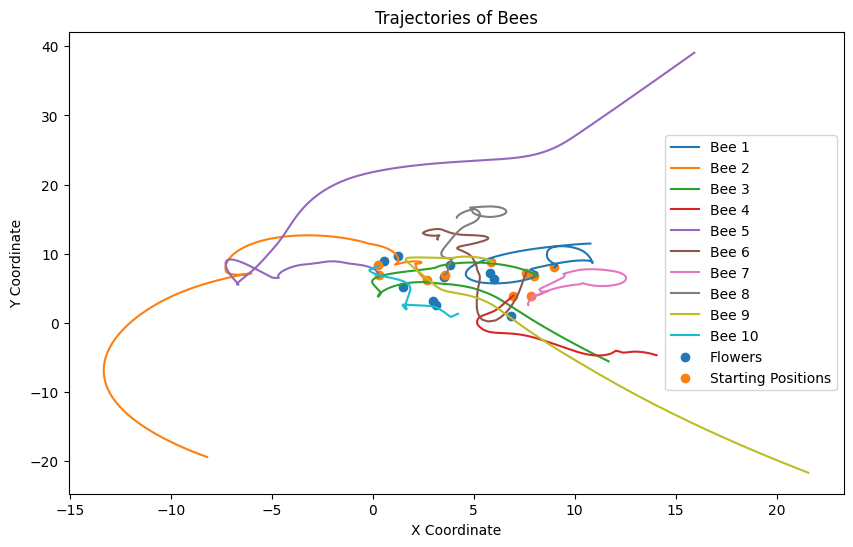

[7.60457572 7.5643918  7.52555693 7.48845544 7.45244108 7.41637334
 7.37863316 7.33729641 7.29095599 7.23854175 7.17918959 7.11224248
 7.03703095 6.95301978 6.85922085 6.75360152 6.63308378 6.48789972
 6.31373471 6.08215389 5.71259252 5.4186042  5.28546278 5.21715811
 5.17876932 5.15955074 5.15275402 5.15441099 5.16186263 5.17107828
 5.18285864 5.19846036 5.21806538 5.24078098 5.26463975 5.2865996
 5.30254376 5.30728078 5.28780472 5.23392844 5.18637628 5.16319538
 5.15297449 5.12041385 5.08613712 5.05921258 5.0353754  5.01168566
 4.98652849 4.95949593 4.93062851 4.90001106 4.86777019 4.83407427
 4.79913341 4.76319952 4.72656622 4.68956894 4.65258482 4.61603281
 4.58037358 4.54610958 4.51362521 4.48226905 4.45204164 4.4231098
 4.39561874 4.36969207 4.34543182 4.32291841 4.30221067 4.28334583
 4.26633952 4.25118579 4.23785707 4.2263042  4.21645643 4.20822142
 4.20148522 4.19611228 4.19194547 4.18880605 4.18649368 4.18486457
 4.18398483 4.18378863 4.18420353 4.1851626  4.18660445 4.188473

In [623]:
# def ode(t, x, nu, xsi, sigma):
#     # Reshape x to be compatible with flower_positions
#     bee_positions = x.reshape((2, -1))
#     # Calculate the distance from each bee to each flower
#     distance = bee_positions[:, :, np.newaxis] - flower_positions[:, np.newaxis, :] 
#     # Calculate the velocity vector for each bee towards each flower
#     velocity_vector = attraction_to_flower(attraction_differences, distance, sigma)
#     # Sum the influences of all flowers and normalize
#     velocity = nu * velocity_vector.sum(axis=1) / (xsi + np.linalg.norm(velocity_vector.sum(axis=1), axis=0, keepdims=True))
#     return velocity.flatten()

def ode(t, x, nu, xsi, sigma, gamma, T_i, decay_factor, eps):
    bee_positions = x.reshape((2, -1))
    distance = bee_positions[:, :, np.newaxis] - flower_positions[:, np.newaxis, :] 

    # Update gamma based on the current time and visitation status
    gamma = gamma_update(gamma, decay_factor=decay_factor, t=t, T_i=T_i)

    velocity_vector = attraction_to_flower(attraction_differences, distance, gamma, sigma)
    velocity = nu * velocity_vector.sum(axis=1) / (xsi + np.linalg.norm(velocity_vector.sum(axis=1), axis=0, keepdims=True))
    
    # Check and update visitation status
    for i, d in enumerate(distance.T):  # Loop over flowers
        if np.any(np.linalg.norm(d, axis=0) < eps):  # Check if any bee is close enough to the flower
            T_i[i] = t if T_i[i] == -1 else T_i[i]  # Update the visitation time if not previously visited

    return velocity.flatten()

# # Initialize positions and preferences
# flower_positions = random_flower_position(num_flowers=flower_qnty, max_position=max_position)
# bee_positions = random_bee_position(num_bees=bee_qnty, max_position=max_position)
# bee_preferences = random_bee_attraction(features=features, num_bees=bee_qnty, max_attraction=max_attraction)
# flower_attraction = random_flower_attraction(num_flowers=flower_qnty, features=features, max_attraction=max_attraction)

# Calculate the differences in attraction
attraction_differences = bee_preferences[:, :, np.newaxis] - flower_attraction[:, np.newaxis, :]

# # Solve the ODE for the trajectories of the bees
# sol = solve_ivp(ode, [0, 100], bee_positions.flatten(), args=(3, 1, .5), dense_output=True)
# Gamma and Time of Visit Initialization
n = flower_qnty  # Number of flowers
gamma = np.ones(n)  # Initialize gamma as a vector of ones
T_i = -np.ones(n)  # Initialize T_i as a vector of negative ones (indicating no visits yet)
decay_factor = 1.0  # Decay rate for gamma
eps = 1  # Epsilon for distance to flower

# Parameters for the ODE
nu = 10
xsi = 1
sigma = 1

# Define the time span for the simulation
t_span = [0, 100]  # Start and end times

# Flatten the initial bee positions for solve_ivp
initial_conditions = bee_positions.flatten()

# Call solve_ivp
solution = solve_ivp(ode, t_span, initial_conditions, args=(nu, xsi, sigma, gamma, T_i, decay_factor, eps), dense_output=True)

# Extract the solution
trajectory = solution.sol


# Define time points at which to evaluate the solution
time_points = np.linspace(t_span[0], t_span[1], t_span[1] * 10)
trajectories = solution.sol(time_points)

# Plotting
plt.figure(figsize=(10, 6))

num_bees = bee_qnty  # Number of bees
for i in range(num_bees):
    # Extracting the x and y coordinates of the i-th bee
    x = trajectories[i, :]
    y = trajectories[num_bees + i, :]
    plt.plot(x, y, label=f'Bee {i+1}')
# plot the flowers
plt.scatter(flower_positions[0, :], flower_positions[1, :], label='Flowers')
# plot the starting positions of the bees
plt.scatter(bee_positions[0, :], bee_positions[1, :], label='Starting Positions')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Trajectories of Bees')
plt.legend()
plt.show()

# print the trajectory points of bee # 6
print(trajectories[5, :])




In [586]:
def ode(t, x, nu, xsi, sigma, gamma, T_i, decay_factor, eps):
    bee_positions = x.reshape((2, -1))
    distance = bee_positions[:, :, np.newaxis] - flower_positions[:, np.newaxis, :] 

    # Update gamma based on the current time and visitation status
    gamma = gamma_update(gamma, decay_factor=decay_factor, t=t, T_i=T_i)

    velocity_vector = attraction_to_flower(attraction_differences, distance, gamma, sigma)
    velocity = nu * velocity_vector.sum(axis=1) / (xsi + np.linalg.norm(velocity_vector.sum(axis=1), axis=0, keepdims=True))
    
    # Check and update visitation status
    for i, d in enumerate(distance.T):  # Loop over flowers
        if np.any(np.linalg.norm(d, axis=0) < eps):  # Check if any bee is close enough to the flower
            T_i[i] = t if T_i[i] == -1 else T_i[i]  # Update the visitation time if not previously visited

    return velocity.flatten()

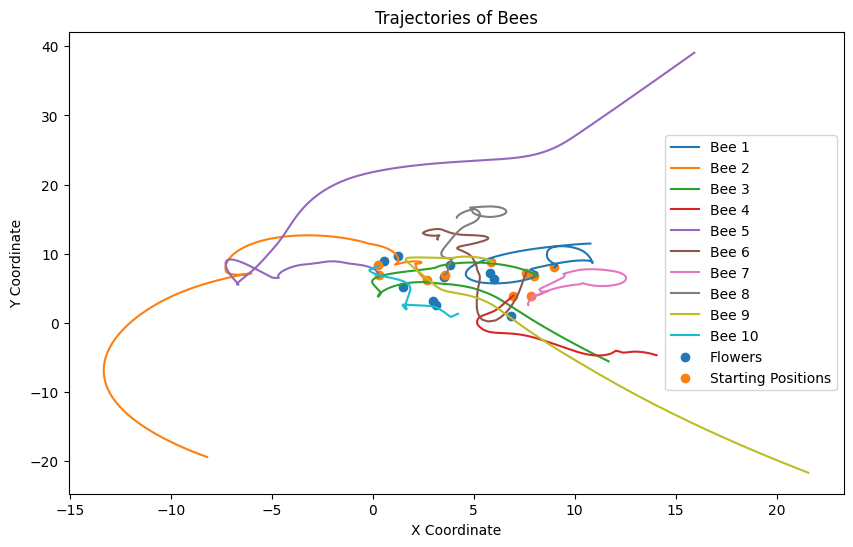

[  2.70128976   2.64388317   2.59043938   2.53968006   2.49126483
   2.44523444   2.40199799   2.36227777   2.32666416   2.29543136
   2.26857817   2.24582809   2.22671148   2.21074119   2.19741916
   2.18628189   2.17690055   2.16889832   2.16197957   2.1558916
   2.15042876   2.14542826   2.14076126   2.13632496   2.1320395
   2.12782729   2.12362367   2.11941012   2.11495048   2.10831914
   2.1025188    2.10100715   2.10627038   2.11982316   2.14220864
   2.17299846   2.21079276   2.25322016   2.29679621   2.33678463
   2.36978324   2.3940162    2.40926973   2.4169527    2.41988342
   2.41944399   2.41648054   2.41163968   2.40536989   2.3979943
   2.38962173   2.38027107   2.36994733   2.35864165   2.34633132
   2.33297977   2.31853652   2.30293728   2.28610386   2.26794421
   2.24835241   2.22720869   2.20438101   2.17974144   2.15317984
   2.12462267   2.09403522   2.0614216    2.02682475   1.99032641
   1.95204718   1.91214647   1.8708225    1.82831233   1.78489184
   1.74087574

In [631]:
# Gamma and Time of Visit Initialization
n = flower_qnty  # Number of flowers
gamma = np.ones(n)  # Initialize gamma as a vector of ones
T_i = -np.ones(n)  # Initialize T_i as a vector of negative ones (indicating no visits yet)
decay_factor = 1.0  # Decay rate for gamma
eps = 0.1  # Epsilon for distance to flower

# Parameters for the ODE
nu = 10
xsi = 1
sigma = 1

# Define the time span for the simulation
t_span = [0, 100]  # Start and end times

# Flatten the initial bee positions for solve_ivp
initial_conditions = bee_positions.flatten()

# Call solve_ivp
solution = solve_ivp(ode, t_span, initial_conditions, args=(nu, xsi, sigma, gamma, T_i, decay_factor, eps), dense_output=True)

# Extract the solution
trajectory = solution.sol


# Define time points at which to evaluate the solution
time_points = np.linspace(t_span[0], t_span[1], t_span[1] * 10)
trajectories = solution.sol(time_points)

# Plotting
plt.figure(figsize=(10, 6))

num_bees = bee_qnty  # Number of bees
for i in range(num_bees):
    # Extracting the x and y coordinates of the i-th bee
    x = trajectories[i, :]
    y = trajectories[num_bees + i, :]
    plt.plot(x, y, label=f'Bee {i+1}')
# plot the flowers
plt.scatter(flower_positions[0, :], flower_positions[1, :], label='Flowers')
# plot the starting positions of the bees
plt.scatter(bee_positions[0, :], bee_positions[1, :], label='Starting Positions')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Trajectories of Bees')
plt.legend()
plt.show()

# print the trajectory points of bee # 5
print(trajectories[1, :])


